<a href="https://colab.research.google.com/github/nyoons/ESAA/blob/main/2022_12_30_%EA%B3%BC%EC%A0%9C_%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>**06. 군집화 실습 - 고객 세그먼테이션**

**고객 세그먼테이션의 정의와 기법**

다양한 기준으로 고객을 분류하는 기법 지칭. 타깃 마켓팅.

고객의 어떤 요소를 기반으로 군집화할 것인가를 결정하는 것이 중요. 기본적인 고객 분석 요소인 RFM 기법을 이용하자.

**데이터 세트 로딩과 데이터 클렌징**

In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df=pd.read_excel('Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


제품 주문 데이터 세트. invoice(주문번호)+stockcode(제품코드)를 기반으로 주문량, 주문 일자, 제품 단가, 주문 고객 번호, 주문 고객 국가 등의 칼럼으로 구성됨.

In [2]:
#전체 건수, 칼럼 타입, null 개수 확인
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


CustomerID null 값 너무 많다. 다른 칼럼도 오류 데이터 존재. 정제 작업 필요.
* null 데이터 제거 : 특히 CustomerID. 필요 없으니 삭제
* 오류 데이터 삭제 : quantity, unitprice가 0보다 작은 경우. 모두 삭제.

In [3]:
#불린 인덱싱으로 quantity, unitprice >0, customerID가 null 아닌 값만 다시 필터링
retail_df=retail_df[retail_df['Quantity']>0]
retail_df=retail_df[retail_df['UnitPrice']>0]
retail_df=retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [4]:
#Country 칼럼을 보자
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [5]:
#영국이 대다수니까 다른 국가의 데이터는 모두 삭제
retail_df=retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


**RFM 기반 데이터 가공**

군집화 시행 전, 필요한 데이터를 가공해보자.

In [6]:
#quantity와 unitprice 곱해서 주문 금액 데이터를 만들자
#customerNo도 편리한 식별을 위해 float형을 int형으로 변경
retail_df['sale_amount']=retail_df['Quantity']*retail_df['UnitPrice']
retail_df['CustomerID']=retail_df['CustomerID'].astype(int)

이 데이터 세트는 주문 횟수와 주문 금액이 압도적으로 특정 고객에게 많은 특성을 가짐. top-5 주문 건수와 주문 금액을 가진 고객 데이터 추출해보자.

In [7]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


invoiceNo+StockCode로 groupby 수행 시 거의 1에 가깝게 유일한 식별자 레벨이 됨.

In [8]:
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

하지만 RFM 기반의 고객 세그먼테이션은 고객 레벨로 주문 기간, 주문 횟수, 주문 금액 데이터를 기반으로 해 세그먼테이션을 수행. 주문번호+상품코드 기준의 데이터를 고객 기준의 Recency, Frequency, Monetary value 데이터로 변경하자. 주문 번호 기준의 데이터를 개별 고객 기준의 데이터로 groupby.

주문번호 기준의 retail_df에 groupby 적용해 CustomerID 기준으로 데이터 프레임을 새롭게 생성. 연산 위해 agg() 이용.

In [9]:
#DF의 groupby()의 multiple 연산을 위해 agg() 이용
#Recency는 InvoiceDate 칼럼의 max()에서 데이터 가공
#Frequency는 InvoiceNo 칼럼의 count(), Monetary value는 sale_amount 칼럼의 sum()
aggregations={
    'InvoiceDate':'max',
    'InvoiceNo':'count',
    'sale_amount':'sum'
    }
cust_df=retail_df.groupby('CustomerID').agg(aggregations)
#groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df=cust_df.rename(columns={'InvoiceDate':'Recency',
                                'InvoiceNo':'Frequency',
                                'sale_amount':'Monetary'})
cust_df=cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


recency 칼럼은 가장 최근의 주문. 데이터 가공이 추가로 필요. 오늘(2011년 12월 10일) 날짜를 기준으로 가장 최근 주문 일자를 뺀 날짜.

In [10]:
import datetime as dt

cust_df['Recency']=dt.datetime(2011, 12, 10)-cust_df['Recency']
cust_df['Recency']=cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 칼럼 건수는', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는 (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


이제 수행해보자.

**RFM 기반 고객 세그먼테이션**

소매업체와 개인 고객 주문의 주문 횟수와 주문 금액이 큰 차이. 군집화가 한쪽 군집에만 집중되는 현상이 발생. 히스토그램 확인하고 이렇게 왜곡된 데이터에서 군집화를 수행할 때 어떤 현상이 발생하는지 보자.

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <a list of 10 Patch objects>)

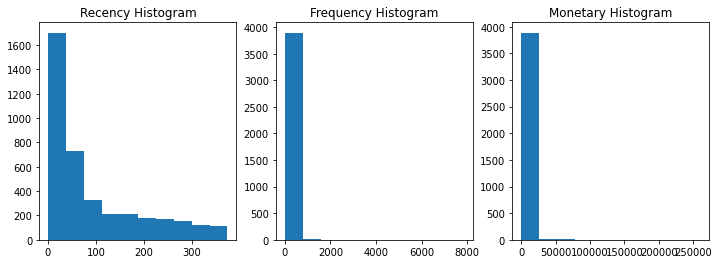

In [11]:
fig, (ax1, ax2, ax3)=plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

In [12]:
#각 칼럼의 데이터 값 백분위로 대략적으로 어떻게 분포돼 있는지 확인하자
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


평균과 중위값, max 값을 보니 셋 다 왜곡이 심함.

왜곡 정도가 매우 높은 데이터 세트에 K-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행됨. 데이터 세트를 StandardScaler로 평균과 표준편차를 재조정한 뒤에 K-평균 수행하자.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features=cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled=StandardScaler().fit_transform(X_features)

kmeans=KMeans(n_clusters=3, random_state=0)
labels=kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label']=labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.592


꽤 안정적인 수치. 하지만 각 군집별로 본다면?

In [ ]:
visualize_silhouette([2,3,4,5], X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5], X_features_scaled)

그림을 보자.

군집이 2개일 경우 두 군집이 너무 개괄적으로 군집화됨. 군집 수를 증가시켜도 개선되지 않음. 군집 내부에서 데이터가 너무 광범위하고 각 군집에 속한 데이터 세트의 개수가 너무 적고 광범위하게 퍼져 있음. 특정 소매점의 대량 주문 구매 데이터 때문. 의미없는 군집화로 이어짐. 이렇게 크게 왜곡된 데이터 세트의 도출은 굳이 군집화를 이용하지 않아도 간단한 데이터 분석으로 충분. 지나치게 왜곡된 데이터는 K-평균과 같은 거리 기반 군집화 알고리즘에서 지나치게 일반적인 군집화 결과를 도출하게 됨.

데이터 세트의 왜곡 정도를 낮추기 위해 가장 자주 사용되는 방법은 로그 변환.

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

#Recency, Frequency, Monetary 칼럼에 np.log1p()로 로그 변환
cust_df['Recency_log']=np.log1p(cust_df['Recency'])
cust_df['Frequency_log']=np.log1p(cust_df['Frequency'])
cust_df['Monetary_log']=np.log1p(cust_df['Monetary'])

#로그 변환 데이터에 standardscaler 적용
X_features=cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled=StandardScaler().fit_transform(X_features)

kmeans=KMeans(n_clusters=3, random_state=0)
labels=kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label']=labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

실루엣 스코어는 : 0.303


스코어는 전보다 떨이지지만 이 절대치가 중요한게 아님. 어떻게 개별 군집이 더 균일하게 나뉠 수 있는지가 더 중요.

시각화해보면 앞의 경우보다 더 균일하게 군집화가 구성됐음을 확인할 수 있다. 로그 변환은 효과적.